# 03 - XGBoost Model: Predicting Global Radiation (glorad)

### Objective  
This notebook trains an XGBoost regression model to predict daily global radiation (glorad) using available weather features: rainfall, maximum temperature (maxtp), and minimum temperature (mintp).  

The model aims to serve as the first stage of a two-stage forecasting pipeline, providing an estimated radiation value that can be used to predict daily solar energy generation in the next stage.  

This approach addresses a key challenge in the Irish context — the unavailability of glorad forecasts — by attempting to model glorad from weather features that are available both historically and as forecasts.


### Import and Prepare Data

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from itertools import product


In [ ]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2024.csv")

df.head()

### Train/Test Split


In [7]:
# Select features and target
X = df[['rain', 'maxtp', 'mintp']]
y = df['glorad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Grid Search for Hyperparameters
#### Define Parameter Grid and Result Storage

In [77]:
# Define values to try
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.12],
    'n_estimators': [50, 100, 300, 500]
}

# Generate all combinations of parameters
param_combos = list(product(param_grid['max_depth'],
                            param_grid['learning_rate'],
                            param_grid['n_estimators']))

results = []  # To store results for plotting

In [78]:
#Loop Through and Evaluate Each Combination of hyperparameters
for max_depth, learning_rate, n_estimators in param_combos:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    results.append({
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'r2_train': r2_train,
        'r2_test': r2_test
    })


In [ ]:
# Save to a DataFrame
results_df = pd.DataFrame(results)

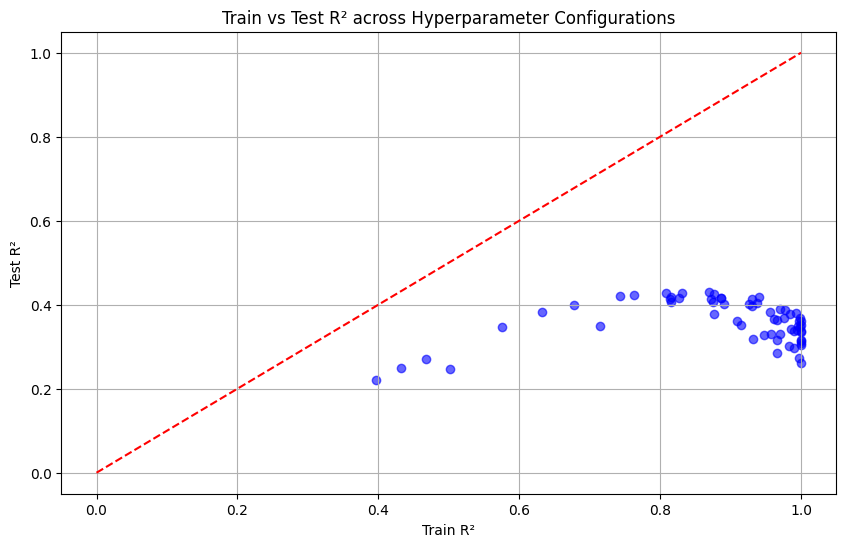

In [ ]:
# Plot Train vs Test R²
plt.figure(figsize=(10, 6))

plt.scatter(results_df['r2_train'], results_df['r2_test'], c='blue', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')  # Reference line y = x

plt.xlabel("Train R²")
plt.ylabel("Test R²")
plt.title("Train vs Test R² across Hyperparameter Configurations")
plt.grid(True)
plt.show()

In [75]:
# Predict on both train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate Train
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train: R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")

# Evaluate Test
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test : R²: {r2_test:.3f} | RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")



Train: R²: 0.733 | RMSE: 355.30 | MAE: 288.22
Test : R²: 0.435 | RMSE: 451.40 | MAE: 367.65
